In [7]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion # for local neighborhoof
from scipy.ndimage.morphology import iterate_structure # for local neighborhood

from typing import Tuple, Callable, List
from typing import List, Tuple, Dict
from microphone import record_audio


%matplotlib notebook

In [9]:
class FingerprintKey:
    def __init__(self, key, ti):
        self.key = key # (fi, fj, delta_t)
        self.ti = ti

def load_audio(song_name):
    '''
    Return the recorded audio and sampling_rate as a Tuple
    '''

    #length = 60  # seconds

    length = 11
    
    return librosa.load(song_name, sr = 44100, duration = length)




def get_spectrogram(recorded_audio, sampling_rate):
    '''
    Return the spectrogram corresponding to `recorded_audio` with `sampling_rate` as the sampling_rate
    '''
   
    return mlab.specgram(recorded_audio,
                            NFFT=4096,
                            Fs=sampling_rate,
                            window=mlab.window_hanning,
                            noverlap=4096//2,
                            mode='magnitude')
    


def put_database(fingerprint_database: Dict[str, str], song_database: List[Tuple[str, str, str]], fingerprint, song):
    fingerprint_database[fingerprint] = song
    song_database.append(song)

In [41]:

recorded_audio, sampling_rate = load_audio('songs/Rasputin.mp3')


/Users/shrutisharma/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [23]:
samples, freqs, times =  get_spectrogram(recorded_audio, sampling_rate)

samples

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.08554792e-04, 8.33178092e-05, 3.03675565e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.78533061e-04, 1.24434045e-04, 2.11865778e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.93280609e-04, 7.82460272e-05, 3.41401720e-04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.27358582e-08, 1.80724872e-08, 4.43078569e-08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.17586339e-07, 6.14354260e-08, 7.96118606e-08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.07864180e-08, 6.44536271e-08, 6.94280681e-08]])

In [38]:
np.max(samples)

0.25294148533896516

In [40]:
def fourier_complex_to_real(complex_coeffs, N):
    """
    Converts complex-valued Fourier coefficients (of 
    real-valued data) to the associated amplitudes and 
    phase-shifts of the real-valued sinusoids
    
    Parameters
    ----------
    complex_coeffs : numpy.ndarray, shape-(N//2 + 1,)
        The complex valued Fourier coefficients for k=0, 1, ...
    
    N : int
        The number of samples that the DFT was performed on.
    
    Returns
    -------
    Tuple[numpy.ndarray, numpy.ndarray]
        (amplitudes, phase-shifts)
        Two real-valued, shape-(N//2 + 1,) arrays
    """
    amplitudes = np.abs(complex_coeffs) / N

    # |a_k| = 2 |c_k| / N for all k except for
    # k=0 and k=N/2 (only if N is even)
    # where |a_k| = |c_k| / N
    amplitudes[1 : (-1 if N % 2 == 0 else None)] *= 2

    phases = np.arctan2(-complex_coeffs.imag, complex_coeffs.real)
    return amplitudes, phases

complex_samples = np.fft.rfft(samples)
amps = fourier_complex_to_real(complex_samples, len(samples))[0]

np.max(amps)


0.008469218930594075

In [24]:
from IPython.display import Audio
Audio(recorded_audio, rate = sampling_rate)

<IPython.core.display.Javascript object>


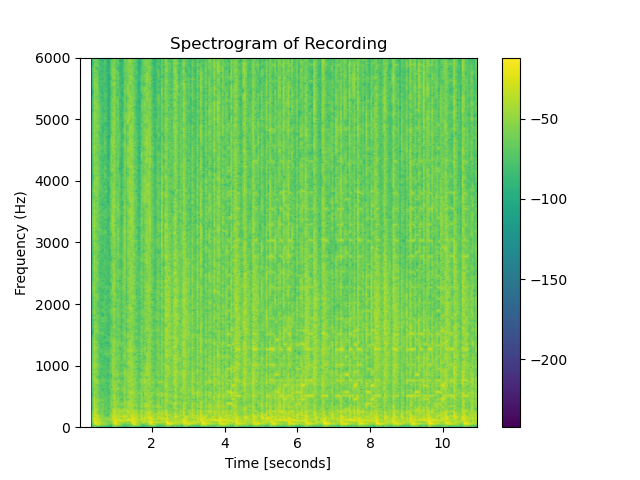

/Users/shrutisharma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7533: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


(0.0, 6000.0)

In [42]:
import matplotlib.mlab as mlab

fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(
    recorded_audio,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=4096 // 2,
    mode='magnitude',
    scale="dB"
)
fig.colorbar(im)

ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Recording")
ax.set_ylim(0, 6000)

<IPython.core.display.Javascript object>


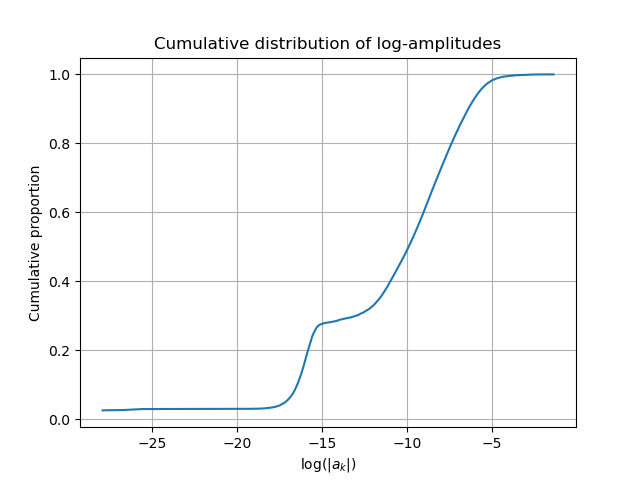

[       -inf        -inf        -inf ... -1.60292037 -1.53670141
 -1.3745971 ]
[2.07677850e-06 4.15355700e-06 6.23033550e-06 ... 9.99995846e-01
 9.99997923e-01 1.00000000e+00]


/Users/shrutisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


In [30]:
import numpy as np

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.
    
    Parameters
    ----------
    data : numpy.ndarray, size-N
    
    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel()  # flattens the data
    y = np.linspace(1 / len(data), 1, len(data))  # stores the cumulative proportion associated with each sorted datum
    x = np.sort(data)
    return x, y
fig, ax = plt.subplots()

x, y = ecdf(np.log(S))
print(x)
print(y)
ax.plot(x, y)

ax.set_xlabel(r"$\log(|a_{k}|)$")
ax.set_ylabel(r"Cumulative proportion")
ax.set_title("Cumulative distribution of log-amplitudes")
ax.grid(True)



In [44]:
log_S = np.log(S).ravel()  # flattened array
ind = round(len(log_S) * 0.9)
cutoff_log_amplitude = np.partition(log_S, ind)[ind]
cutoff_log_amplitude

/Users/shrutisharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-6.3855809870861435

In [45]:
np.exp(-8.78)

0.00015377808519875894

In [32]:
from numba import njit

# `@njit` "decorates" the `_peaks` function. This tells Numba to
# compile this function using the "low level virtual machine" (LLVM)
# compiler. The resulting object is a Python function that, when called,
# executes optimized machine code instead of the Python code
# 
# The code used in _peaks adheres strictly to the subset of Python and
# NumPy that is supported by Numba's jit. This is a requirement in order
# for Numba to know how to compile this function to more efficient
# instructions for the machine to execute
@njit
def _peaks(
    data_2d: np.ndarray, rows: np.ndarray, cols: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    rows : numpy.ndarray, shape-(N,)
        The 0-centered row indices of the local neighborhood mask
    
    cols : numpy.ndarray, shape-(N,)
        The 0-centered column indices of the local neighborhood mask
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location. 
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterate over the 2-D data in col-major order
    # we want to see if there is a local peak located at
    # row=r, col=c

    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c)
        # dr: displacement from r
        # dc: discplacement from c
        for dr, dc in zip(rows, cols):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary
                continue

            # mirror over array boundary
            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a peak
            peaks.append((r, c))
    return peaks

# `local_peak_locations` is responsible for taking in the boolean mask `neighborhood`
# and converting it to a form that can be used by `_peaks`. This "outer" code is 
# not compatible with Numba which is why we end up using two functions:
# `local_peak_locations` does some initial pre-processing that is not compatible with
# Numba, and then it calls `_peaks` which contains all of the jit-compatible code
def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location.
    
    Notes
    -----
    Neighborhoods that overlap with the boundary are mirrored across the boundary.
    
    The local peaks are returned in column-major order.
    """
    
    rows, cols = np.where(neighborhood)
    
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1

    # center neighborhood indices around center of neighborhood
    rows -= neighborhood.shape[0] // 2
    
    cols -= neighborhood.shape[1] // 2
    

    return _peaks(data_2d, rows, cols, amp_min=amp_min)

In [46]:
np.max(S)

0.25294148533896516

In [34]:
def local_peaks_mask(data: np.ndarray, cutoff: float) -> np.ndarray:
    """Find local peaks in a 2D array of data.

    Parameters
    ----------
    data : numpy.ndarray, shape-(H, W)

    cutoff : float
         A threshold value that distinguishes background from foreground

    Returns
    -------
    Binary indicator, of the same shape as `data`. The value of
    1 indicates a local peak."""
    # Generate a rank-2, connectivity-2 binary mask
    neighborhood_mask = generate_binary_structure(2, 2)  # <COGLINE>
    

    # Use that neighborhood to find the local peaks in `data`.
    # Pass `cutoff` as `amp_min` to `local_peak_locations`.
    peak_locations = local_peak_locations(data, neighborhood_mask, cutoff)  # <COGLINE>
   
    print(peak_locations)

    # Turns the list of (row, col) peak locations into a shape-(N_peak, 2) array
    # Save the result to the variable `peak_locations`
    peak_locations = np.array(peak_locations)

    # create a mask of zeros with the same shape as `data`
    
    mask = np.zeros(data.shape, dtype=bool)

    # populate the local peaks with `1`
    mask[peak_locations[:, 0], peak_locations[:, 1]] = 1
    return mask

In [47]:
np.max(samples)

0.25294148533896516

In [33]:
def plot_compare(
    data: np.ndarray,
    peak_finding_function: Callable[[np.ndarray], np.ndarray],
    cutoff: float = -np.inf,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the original data side-by-side with the binary indicator
    for the local peaks.

    Parameters
    ----------
    data : numpy.ndarray, shape=(N, H, W)
        N 2D arrays of shape (H, W)

    peak_finding_function : Callable[[ndarray], ndarray]
        Returns local peak indicator for 2D array

    cutoff : float, optional (default=-np.inf)
         A threshold value that distinguishes background from foreground
         
    Returns
    -------
    Tuple[matplotlib.Figure, matplotlib.Axes]
        The figure and axes objects of the plot
    """
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_finding_function(dat, cutoff=cutoff))
    return fig, ax

In [13]:
np.exp(-8.78)

0.00015377808519875894

In [35]:
local_peaks_mask(samples, 0.00015)

[(12, 8), (18, 8), (22, 8), (27, 8), (31, 8), (37, 8), (41, 8), (44, 8), (52, 8), (56, 8), (61, 8), (70, 8), (74, 8), (77, 8), (80, 8), (82, 8), (85, 8), (91, 8), (94, 8), (96, 8), (99, 8), (103, 8), (105, 8), (108, 8), (111, 8), (114, 8), (118, 8), (122, 8), (128, 8), (133, 8), (141, 8), (151, 8), (157, 8), (163, 8), (166, 8), (173, 8), (177, 8), (185, 8), (189, 8), (199, 8), (202, 8), (210, 8), (215, 8), (222, 8), (224, 8), (228, 8), (234, 8), (239, 8), (243, 8), (250, 8), (256, 8), (259, 8), (268, 8), (271, 8), (273, 8), (276, 8), (282, 8), (285, 8), (287, 8), (291, 8), (296, 8), (302, 8), (305, 8), (308, 8), (311, 8), (314, 8), (317, 8), (320, 8), (322, 8), (325, 8), (327, 8), (330, 8), (335, 8), (341, 8), (354, 8), (357, 8), (360, 8), (365, 8), (369, 8), (382, 8), (385, 8), (388, 8), (391, 8), (399, 8), (403, 8), (406, 8), (411, 8), (414, 8), (417, 8), (419, 8), (422, 8), (431, 8), (439, 8), (446, 8), (460, 8), (464, 8), (467, 8), (470, 8), (473, 8), (480, 8), (488, 8), (495, 8), 

array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [14]:
# pseudocode for making fingerprints for each peak

# make list "peaks" of all peaks, iterate through them with a fanout value and constructa fingerprint

def construct_fingerprint(peaks: List[Tuple[int, int]]) -> List[FingerprintKey]:

    """
    Parameters
    ----------
    peak: List of tuples for peak location, the first value 
    being the peak and the second value being 
    the time at which it occured. 

    peak is the output of  local_peak_locations



    Returns
    -------

    A list of FingerPrintKey objects that make up the whole fingerprint for some peak. This list will be stored in
    the database through the function put_database



    """

    fanout = 15
    fingerprint = []
    # find location of first peak in the list

    for p in range(fanout):
    
        # compare peak time to the next 15 peaks
        abs_time = peaks[0][1] # the time of the first peak recorded
        peak, time = peaks[p]
        next_peak, next_time = peaks[p + 1]
        _print = FingerprintKey((peak, next_peak, next_time - abs_time), abs_time)
        fingerprint.append(_print)
    
    return fingerprint 

